# New Panorama Segmentation

## Imports

In [1]:
import torch
import kornia
import cv2
import numpy as np
import imutils
from glob import glob
import albumentations as albu
from albumentations.pytorch import ToTensorV2 as ToTensor
from scipy.ndimage import gaussian_filter

from matplotlib import pyplot as plt

from matplotlib.colors import ListedColormap

In [2]:
def create_cityscapes_colormap():
    colormap = np.zeros((256, 3), dtype=np.uint8)
    colormap[:19, :] = np.array([
        [128, 64, 128],
        [244, 35, 232],
        [70, 70, 70],
        [102, 102, 156],
        [190, 153, 153],
        [153, 153, 153],
        [250, 170, 30],
        [220, 220, 0],
        [107, 142, 35],
        [152, 251, 152],
        [70, 130, 180],
        [220, 20, 60],
        [255, 0, 0],
        [0, 0, 142],
        [0, 0, 70],
        [0, 60, 100],
        [0, 80, 100],
        [0, 0, 230],
        [119, 11, 32]])
    return ListedColormap(colormap / 255., N=256)

In [3]:
colormap = create_cityscapes_colormap()

In [4]:
torch.set_grad_enabled(False)

# Define Stitcher Class

In [5]:
class Stitcher:
    def __init__(self):
        self.cachedHlc = None
        self.cachedHrc = None
        
    def stitch(self,Masks,result_width,M_left_center,M_center_right):
        (Maskleft_image, Maskcenter_image, Maskright_image) = Masks
        
        self.cachedHlc = M_left_center
        self.cachedHrc = M_center_right
        
        #result_width = 3200
        T = np.array([[1.0, 0.0, (result_width/2)-(Masks[0].shape[3]/2)],
                      [0.0, 1.0, 0.0],
                      [0.0, 0.0, 1.0]]).astype(dtype=np.float32)
        

        transformations = [self.cachedHlc, np.identity(3, dtype=np.float32), self.cachedHrc]
        #result = np.zeros((Masks[0].shape[0],Masks[0].shape[1],result_width)).astype(np.float32)
        #weights = np.zeros_like(result)
        
        result = 0
        weights = 1e-6
        
        for i in range(len(Masks)):
            warp = kornia.warp_perspective(Masks[i], 
                                       torch.tensor(np.dot(T,transformations[i]),dtype=torch.float32), 
                                       (Masks[i].shape[2],result_width))
            weight = kornia.warp_perspective(torch.tensor(np.ones_like(Masks[i])), 
                                       torch.tensor(np.dot(T,transformations[i]),dtype=torch.float32), 
                                       (Masks[i].shape[2],result_width))
            
            
            #result =  kornia.color.add_weighted(torch.tensor(result),1.0,warp,1.0,0.0)
            #weights = kornia.color.add_weighted(torch.tensor(weights),1.0,weight,1.0,0.0)
            result = warp + result
            weights = weights + weight

        return result / weights
        #return np.uint8(kornia.tensor_to_image(result) / kornia.tensor_to_image(weights))
    
    
    def stitchNormal(self,Masks,result_width,M_left_center,M_center_right):
        (Maskleft_image, Maskcenter_image, Maskright_image) = Masks
        
        self.cachedHlc = M_left_center
        self.cachedHrc = M_center_right
        
        #result_width = 3200
        T = np.array([[1.0, 0.0, (result_width/2)-(Masks[0].shape[1]/2)],
                      [0.0, 1.0, 0.0],
                      [0.0, 0.0, 1.0]]).astype(dtype=np.float32)
        

        transformations = [self.cachedHlc, np.identity(3, dtype=np.float32), self.cachedHrc]
        #result = np.zeros((Masks[0].shape[0],Masks[0].shape[1],result_width)).astype(np.float32)
        #weights = np.zeros_like(result)
        
        result = 0
        weights = 1e-6
        
        for i in range(len(Masks)):
            warp = kornia.warp_perspective(Masks[i], 
                                       torch.tensor(np.dot(T,transformations[i]),dtype=torch.float32), 
                                       (Masks[i].shape[0],result_width))
            weight = kornia.warp_perspective(torch.tensor(np.ones_like(Masks[i])), 
                                       torch.tensor(np.dot(T,transformations[i]),dtype=torch.float32), 
                                       (Masks[i].shape[0],result_width))
            
            
            #result =  kornia.color.add_weighted(torch.tensor(result),1.0,warp,1.0,0.0)
            #weights = kornia.color.add_weighted(torch.tensor(weights),1.0,weight,1.0,0.0)
            result = warp + result
            weights = weights + weight

        return result / weights
        #return np.uint8(kornia.tensor_to_image(result) / kornia.tensor_to_image(weights))

    
    
    
    
    def transformationsCalculator(self,images,ratio=0.8, reprojThresh=4.0):
        (image_left, image_center, image_right) = images
        
        (kpsLeft, featuresLeft) = self.detectAndDescribe(image_left)
        (kpsCenter, featuresCenter) = self.detectAndDescribe(image_center)
        (kpsRight, featuresRight) = self.detectAndDescribe(image_right)

        if kpsLeft is None or kpsCenter is None or kpsRight is None:
            print("It was not possible to extract the keypoints")
            return None
        print("Chegou ate aqui")
        M_left_center = self.matchKeypoints(kpsLeft, kpsCenter,featuresLeft, featuresCenter, ratio, reprojThresh)
        M_right_center = self.matchKeypoints(kpsRight, kpsCenter,featuresRight, featuresCenter, ratio, reprojThresh)

        if M_left_center is None or M_right_center is None:
            print("Uma das matrizes nao foi calculada")
            return None
        print("supostamente calculou tudo")
        return (M_left_center[1],M_right_center[1])
    
    def detectAndDescribe(self, image):
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        detector = cv2.ORB_create(nfeatures=1000)
        kps = detector.detect(gray, None)
        (kps,features) = detector.compute(gray, kps)
        kps = np.float32([kp.pt for kp in kps])
        return (kps,features) 
    
    def matchKeypoints(self, kpsA, kpsB, featuresA, featuresB, ratio, reprojThresh):
        matcher = cv2.DescriptorMatcher_create("BruteForce")
        rawMatches = matcher.knnMatch(featuresA, featuresB, 2)
        matches = []
        for m in rawMatches:
            if len(m) == 2 and m[0].distance < m[1].distance * ratio:
                matches.append((m[0].trainIdx, m[0].queryIdx))
        if len(matches) > 15:
            ptsA = np.float32([kpsA[i] for (_, i) in matches])
            ptsB = np.float32([kpsB[i] for (i, _) in matches])
            (H, status) = cv2.findHomography(ptsA, ptsB, cv2.RANSAC,reprojThresh)
            return (matches, H, status)
        return None


## Import Model

In [6]:
model = torch.jit.load('contextnet14_bdd100k_miou0.503.pth')
model = model.cuda()

## Import Images

In [33]:
########Imagens para CALIBRAÇÃO##########
ID = 71
CAMADA = 19
#########################################

#ID = 34
#CAMADA = 56

imagesDireita = glob(f'imagens_novas/D-_{ID:04d}_Camada {CAMADA}.jpg')
imagesEsquerda = glob(f'imagens_novas/E-_{ID:04d}_Camada {CAMADA}.jpg')
imagesMeio = glob(f'imagens_novas/M-_{ID:04d}_Camada {CAMADA}.jpg')

imgsD = np.stack([ cv2.imread(f) for f in imagesDireita ])
imgsE = np.stack([ cv2.imread(f) for f in imagesEsquerda ])
imgsM = np.stack([ cv2.imread(f) for f in imagesMeio ])


imgsD = np.stack([ cv2.resize(img, (1280,736 )) for img in imgsD ])
imgsE= np.stack([ cv2.resize(img, (1280,736 )) for img in imgsE ])
imgsM = np.stack([ cv2.resize(img, (1280,736 )) for img in imgsM ])

imgsD = imgsD[..., ::-1]
imgsE = imgsE[..., ::-1]
imgsM = imgsM[..., ::-1]

imgsD = imgsD[:, :, ...]
imgsE = imgsE[:, :, ...]
imgsM = imgsM[:, :, ...]
imgsD.shape

(1, 736, 1280, 3)


(1, 736, 1280, 3)

In [10]:
tfms = albu.Compose([
    albu.Normalize(),
    ToTensor(),
])

In [11]:
xD = torch.stack([ tfms(image=image)['image'] for image in imgsD ])
xE = torch.stack([ tfms(image=image)['image'] for image in imgsE ])
xM = torch.stack([ tfms(image=image)['image'] for image in imgsM ])

In [12]:
with torch.no_grad():
    yD = model(xD.cuda()).cpu()
    yE = model(xE.cuda()).cpu()
    yM = model(xM.cuda()).cpu()

In [13]:
left_image = imgsE[0]
center_image = imgsM[0]
right_image = imgsD[0]
print(left_image.shape)

classesD = torch.argmax(yD, dim=1)
classesE = torch.argmax(yE, dim=1)
classesM = torch.argmax(yM, dim=1)

Segmentacao=0
if Segmentacao==1:
    outputD = 0.5 * (imgsD / 255.) + 0.5 * colormap(classesD)[..., :3]
    outputE = 0.5 * (imgsE / 255.) + 0.5 * colormap(classesE)[..., :3]
    outputM = 0.5 * (imgsM / 255.) + 0.5 * colormap(classesM)[..., :3]
else:
    outputD = classesD
    outputE = classesE
    outputM = classesM

print(outputD.shape)
print(yD.shape)

print(yD[:,0,:,:].shape)



(736, 1280, 3)
torch.Size([1, 736, 1280])
torch.Size([1, 19, 736, 1280])
torch.Size([1, 736, 1280])


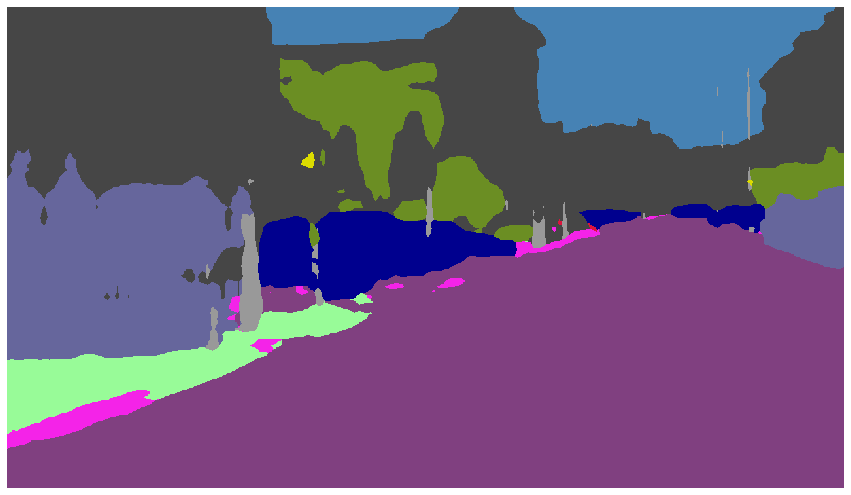

In [14]:
fig, ax = plt.subplots(figsize=(15, 15))
ax.imshow(colormap(outputE[0]))
ax.set_axis_off()
#plt.savefig('Seg-D-_0039_Camada 51.jpg', dpi=500)

In [15]:
outputE.shape

torch.Size([1, 736, 1280])

## Calcular Transformações

In [16]:
result_width=2300

stitcher = Stitcher()

(M_left_center, M_center_right) =stitcher.transformationsCalculator([left_image,center_image, right_image],ratio=0.8, reprojThresh=4.0)

Chegou ate aqui
supostamente calculou tudo


## Imagem Panorâmica com argmax

Criei panorâmica só com a estrada


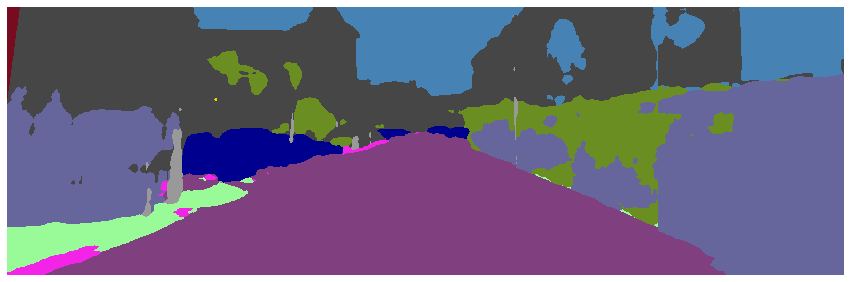

In [17]:
stitcher = Stitcher()

resultMask=torch.zeros([1,19,736,2300])

if left_image is not None and center_image is not None and right_image is not None:
    
    for i in range(19):
        data = yE[:,i:i+1,:,:]  # BxCxHxW
        data2 = yM[:,i:i+1,:,:]
        data3 = yD[:,i:i+1,:,:]
        # print("Calculei os inputs")
        
        resultMask[:,i,:,:] = stitcher.stitch([data.float(),data2.float(), data3.float()],result_width,M_left_center,M_center_right)
    # print(resultMask)
    A=torch.argmax(resultMask, dim=1)
    # print(resultMask.shape)
    if resultMask is None:
        print("There was an error in the stitching procedure")
    else:
        print("Criei panorâmica só com a estrada")
        fig, ax = plt.subplots(figsize=(15, 15))
        ax.set_axis_off()
        ax.imshow(colormap(A[0]))
        fig.show()
else:
    print("Falta as imagens!")

## Imagem Panorâmica Normal

In [62]:
LI=torch.from_numpy(left_image.copy())
MI=torch.from_numpy(center_image.copy())
RI=torch.from_numpy(right_image.copy())
LI=LI[None, :, :]
LI=LI.permute(0,3, 1, 2)
MI=MI[None, :, :]
MI=MI.permute(0,3, 1, 2)
RI=RI[None, :, :]
RI=RI.permute(0,3, 1, 2)
LI.float
MI.float
RI.float

<function Tensor.float>

Criei panorâmica só com a estrada


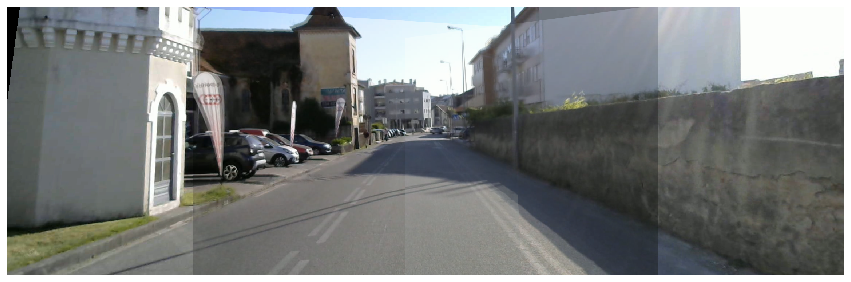

In [63]:
stitcher = Stitcher()
if left_image is not None and center_image is not None and right_image is not None:
    
    #resultMaskFinal = stitcher.stitchNormal([torch.from_numpy(imgsE.copy().astype()),torch.from_numpy(imgsM.copy()), torch.from_numpy(imgsD.copy())],result_width,M_left_center,M_center_right)
    resultMaskFinal = stitcher.stitch([LI.float(),MI.float(),RI.float()],result_width,M_left_center,M_center_right)
    resultMaskFinal=resultMaskFinal[-1,:,:,:].permute(1, 2,0)
    if resultMaskFinal is None:
        print("There was an error in the stitching procedure")
    else:
        print("Criei panorâmica só com a estrada")
        fig, ax = plt.subplots(figsize=(15, 15))
        ax.imshow(resultMaskFinal/ 255.)
        ax.set_axis_off()
        #plt.savefig('Results/Mask_Context_BDD_503-052.png', dpi=500)
else:
    print("Falta as imagens!")

## Imagem Panorâmica Segmentada

In [65]:
PanSegmentada = 0.5 * (resultMaskFinal/ 255.) + 0.5 * colormap(A[0])[..., :3]

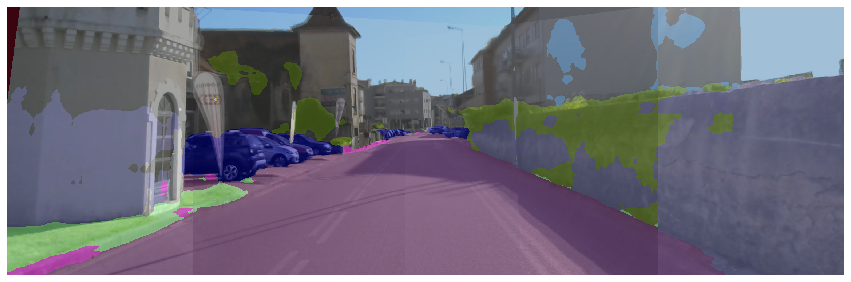

In [66]:
fig, ax = plt.subplots(figsize=(15, 15))
ax.imshow(PanSegmentada)
ax.set_axis_off()

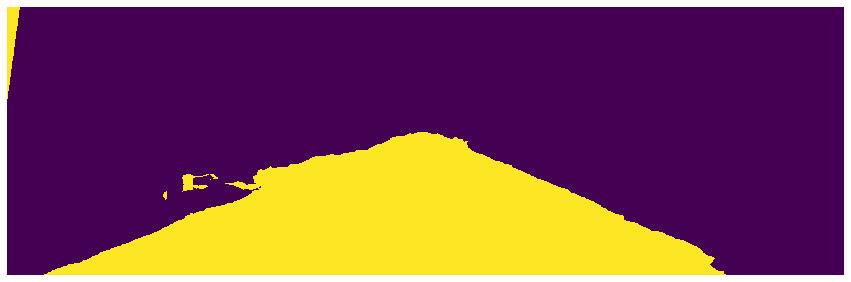

In [41]:
fig, ax = plt.subplots(figsize=(15, 15))
ax.imshow(resultMaskFinal==0)
ax.set_axis_off()